Пронозирование типа лесного покрова

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm

from imblearn.under_sampling import NearMiss		#для понижения размерности данных

%matplotlib inline

In [2]:
# Загрузка данных, чтение датасета
train = pd.read_csv('datasets/covtype.data', delimiter=',', header=None)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
#размерность датасета
train.shape

(581012, 55)

In [4]:
# загрузка файла с названиями столбцов для дальнейшней замены наименования столбцов
names_columns = pd.read_csv('names_columns.csv', delimiter=',')
names_columns.head()

,names
0,Elevation
1,Aspect
2,Slope
3,Horizontal_Distance_To_Hydrology
4,Vertical_Distance_To_Hydrology


In [5]:
# создаем список с названиями столбцов
arr_names = names_columns['names'].values
list_names = arr_names.tolist()

In [6]:
# перезаписываем датасет с новыми названиями столбцов
train = pd.DataFrame(train.values, columns=list(list_names))
train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [7]:
# общая информация по датасету
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [8]:
#Кол-во классов целевой переменной Cover TYpe
print(train['Cover_Type'].value_counts())

# Целевая переменная
print(train['Cover_Type'].unique())

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64
[5 2 1 7 3 6 4]


In [9]:
#делаем копию датасета для возможного отката изменений
train_copy = train.copy()

In [10]:
# уменьшаем размерность датасета
for column in train_copy.columns:
	if 'Soil' in column or 'Wilderness' in column:
		train_copy[column] = train_copy[column].astype('int8')

train_copy['Slope'] = train_copy['Slope'].astype('int8')
train_copy['Cover_Type'] = train_copy['Cover_Type'].astype('int8')

cols_int16 = ['Elevation', 'Aspect', 'Horizontal_Distance_To_Hydrology', \
				  'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', \
					'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

for col in cols_int16:
	train_copy[col] = train_copy[col].astype('int16')

train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int16
 1   Aspect                              581012 non-null  int16
 2   Slope                               581012 non-null  int8 
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int16
 4   Vertical_Distance_To_Hydrology      581012 non-null  int16
 5   Horizontal_Distance_To_Roadways     581012 non-null  int16
 6   Hillshade_9am                       581012 non-null  int16
 7   Hillshade_Noon                      581012 non-null  int16
 8   Hillshade_3pm                       581012 non-null  int16
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int16
 10  Wilderness_Area1                    581012 non-null  int8 
 11  Wilderness_Area2                    581012 non-null 

In [11]:
# создаем классы от 0 до 6 вместо 1-7
# во избежания конфликтов при обучении моделей LGBMClassifier и нейронной сети
train_copy['Cover_Type'] = train_copy['Cover_Type'].map(lambda x: 0 if x==1 else x)
train_copy['Cover_Type'] = train_copy['Cover_Type'].map(lambda x: 1 if x==2 else x)
train_copy['Cover_Type'] = train_copy['Cover_Type'].map(lambda x: 2 if x==3 else x)
train_copy['Cover_Type'] = train_copy['Cover_Type'].map(lambda x: 3 if x==4 else x)
train_copy['Cover_Type'] = train_copy['Cover_Type'].map(lambda x: 4 if x==5 else x)
train_copy['Cover_Type'] = train_copy['Cover_Type'].map(lambda x: 5 if x==6 else x)
train_copy['Cover_Type'] = train_copy['Cover_Type'].map(lambda x: 6 if x==7 else x)

In [12]:
#смотрим какие признаки у нас есть
train_copy.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

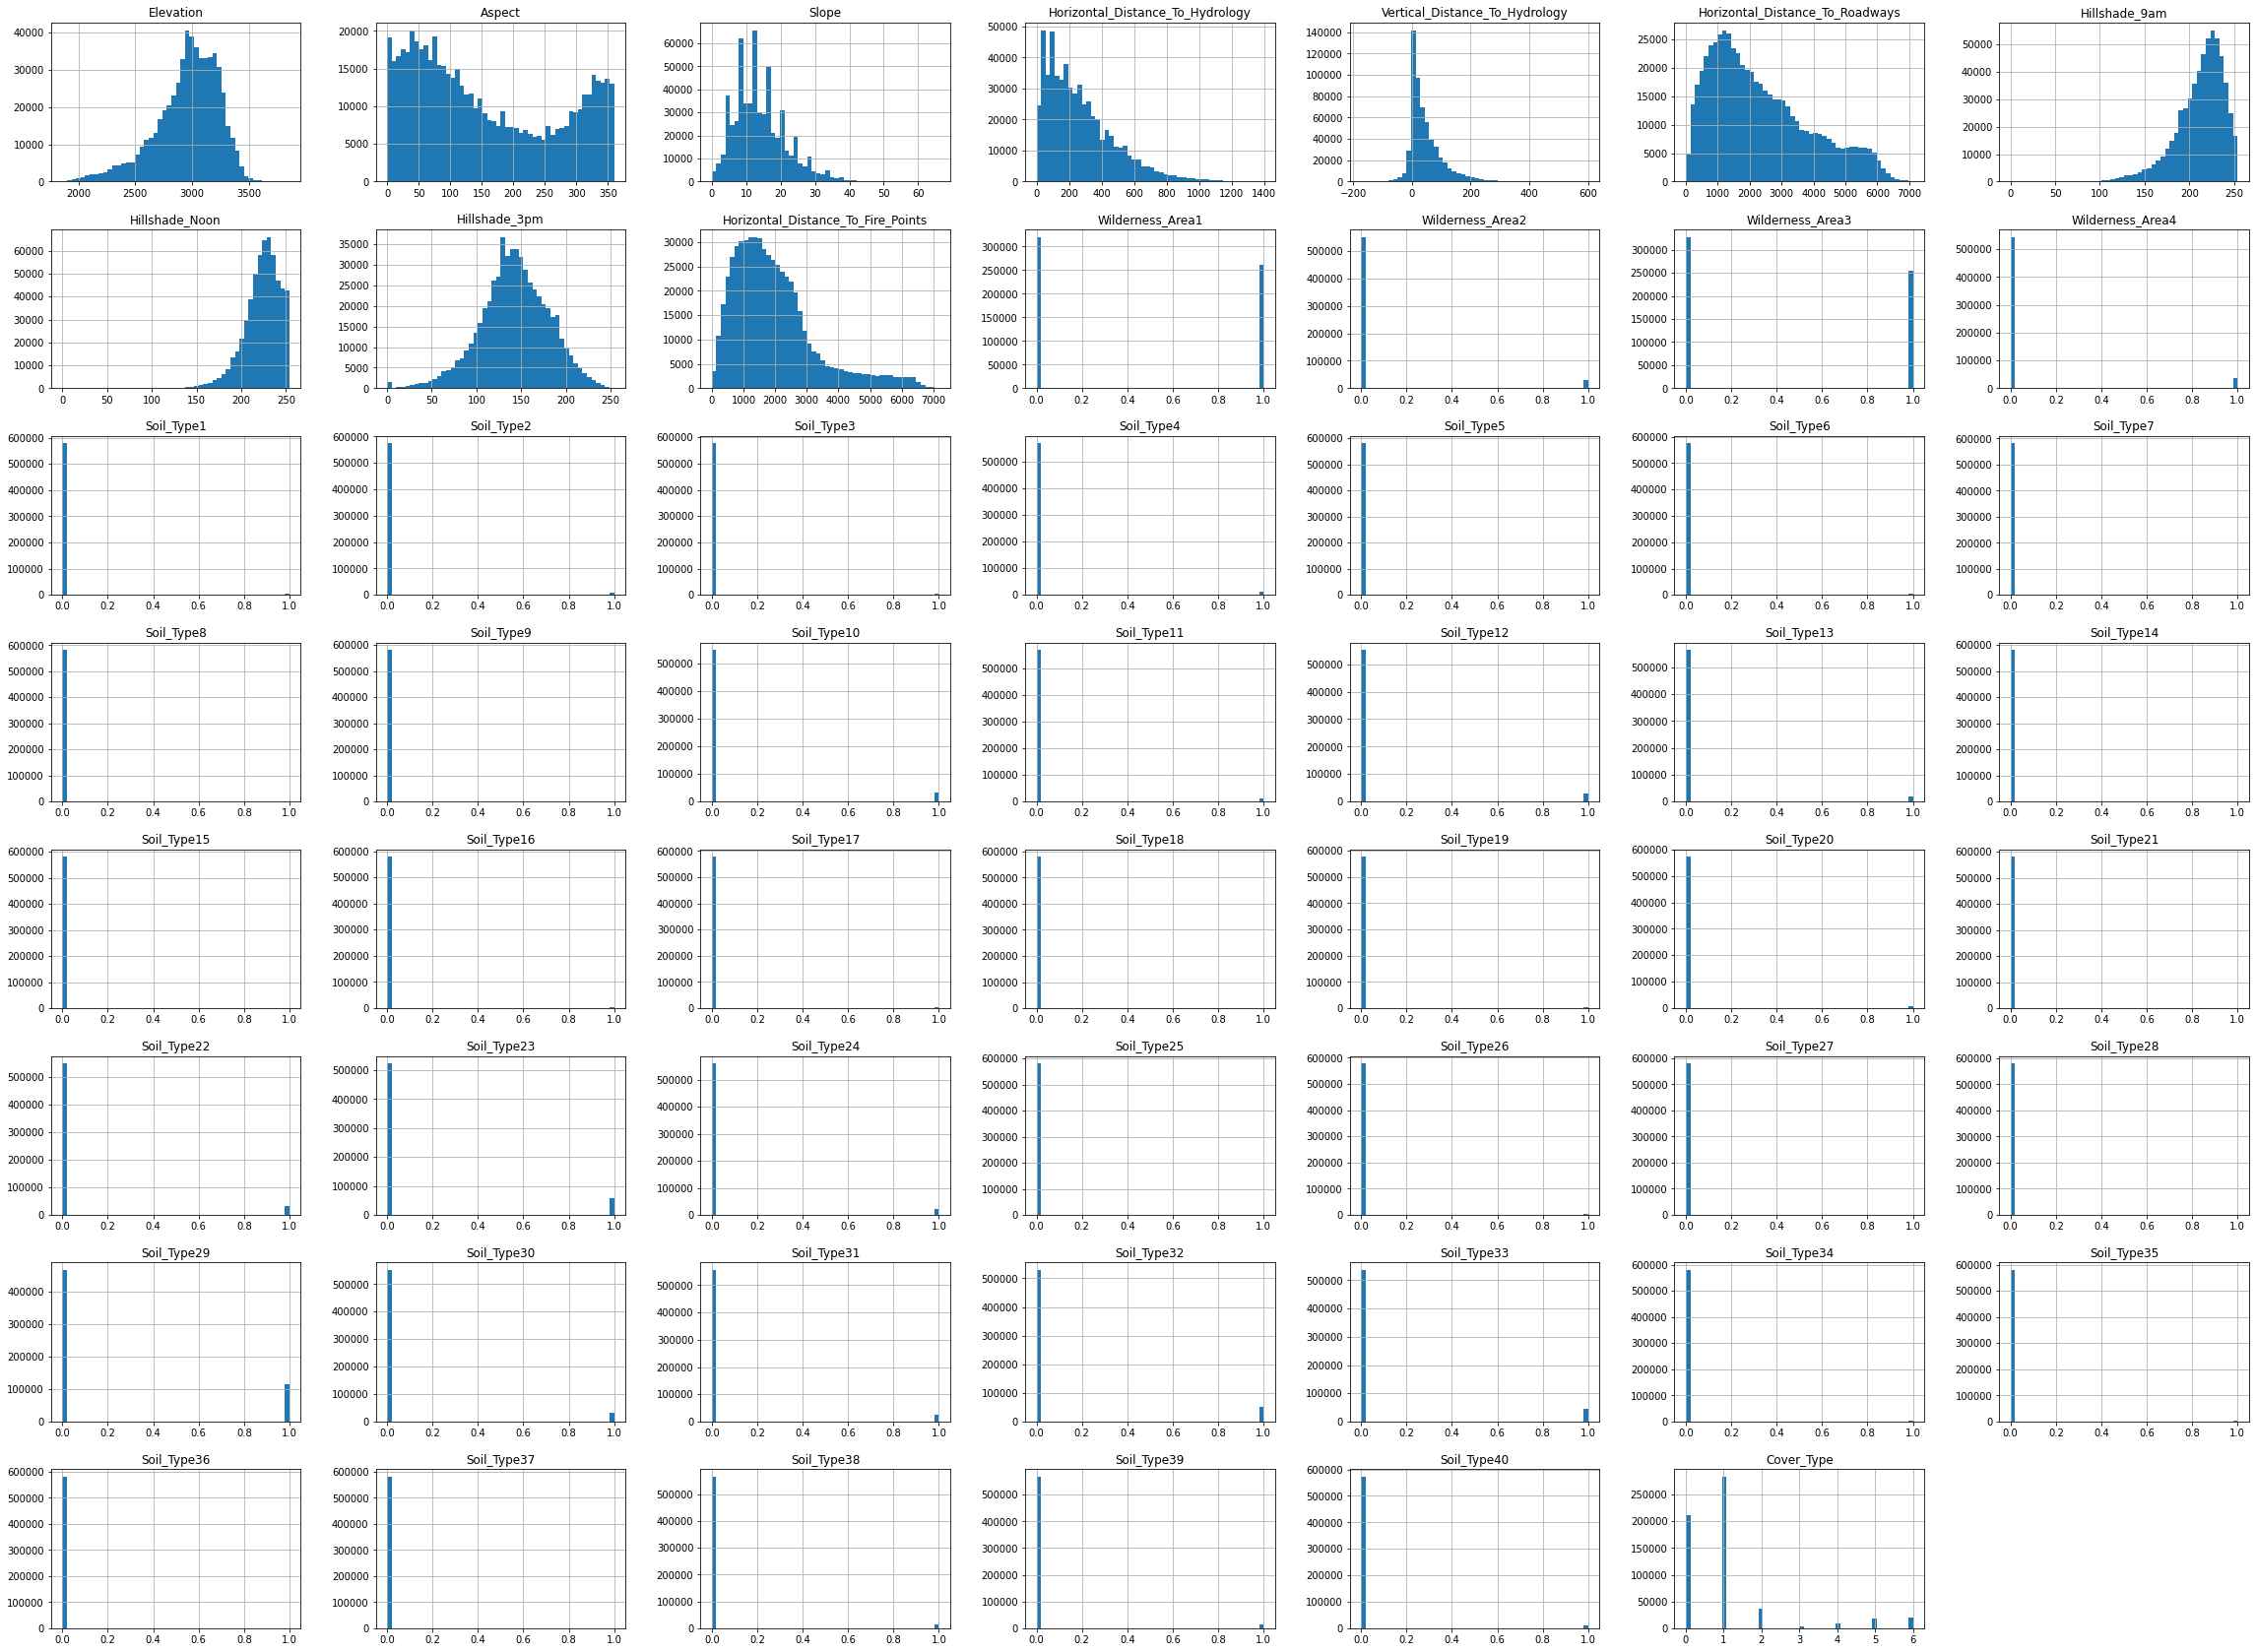

In [13]:
# смотрим на распределения признаков
train_copy.hist(figsize=(40,30), bins=50);

In [14]:
#создаем функцию для отбора признаков
def get_feats(df, black_list=set(['Cover_Type'])):
	feats = df.select_dtypes(np.number).columns
	return [x for x in feats if x not in black_list]

feats= get_feats(train_copy)

In [15]:
# Определяем X-features, y-target
X = train_copy[feats].values
y = train_copy['Cover_Type'].values

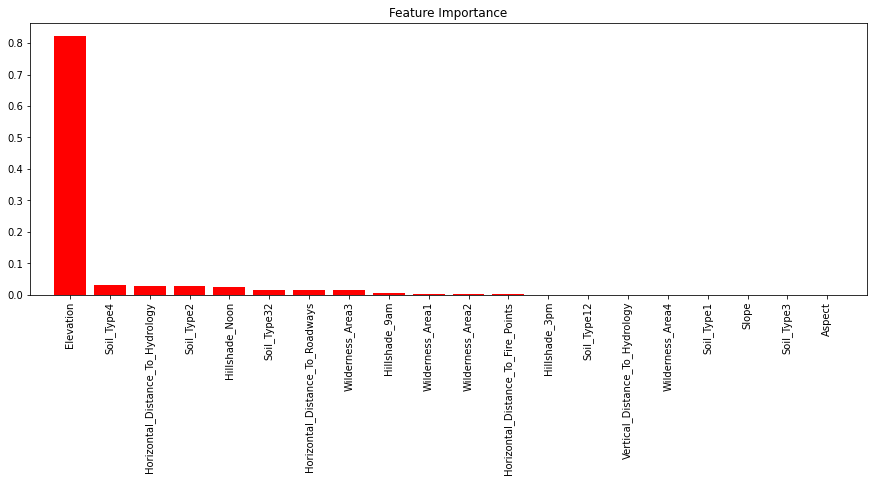

In [16]:
#Построим модель DecisionTreeClassifier для просмотра важности признаков
model = DecisionTreeClassifier(max_depth=5)
model.fit(X, y)

# На графике видно, что Elevation по сути самый важный признак для обучения модели
skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15,5));

array([0.51232244, 0.61910147, 0.5752259 ])

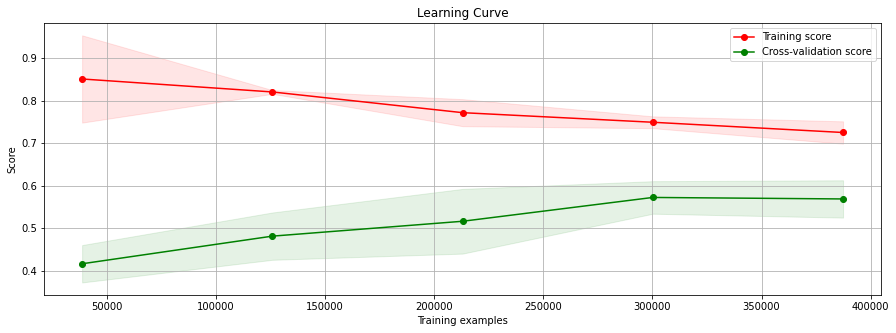

In [17]:
#построим кривую обучения
#видно что модель недообучена и необходимы приобразования признаков или улучшения модели
skplt.estimators.plot_learning_curve(model, X, y, figsize=(15,5), cv=3, scoring='accuracy');

# Убеждаемся, что модель работает плохо. Ср.точность меньше 60%
cross_val_score(model, X, y, cv=3, scoring='accuracy')

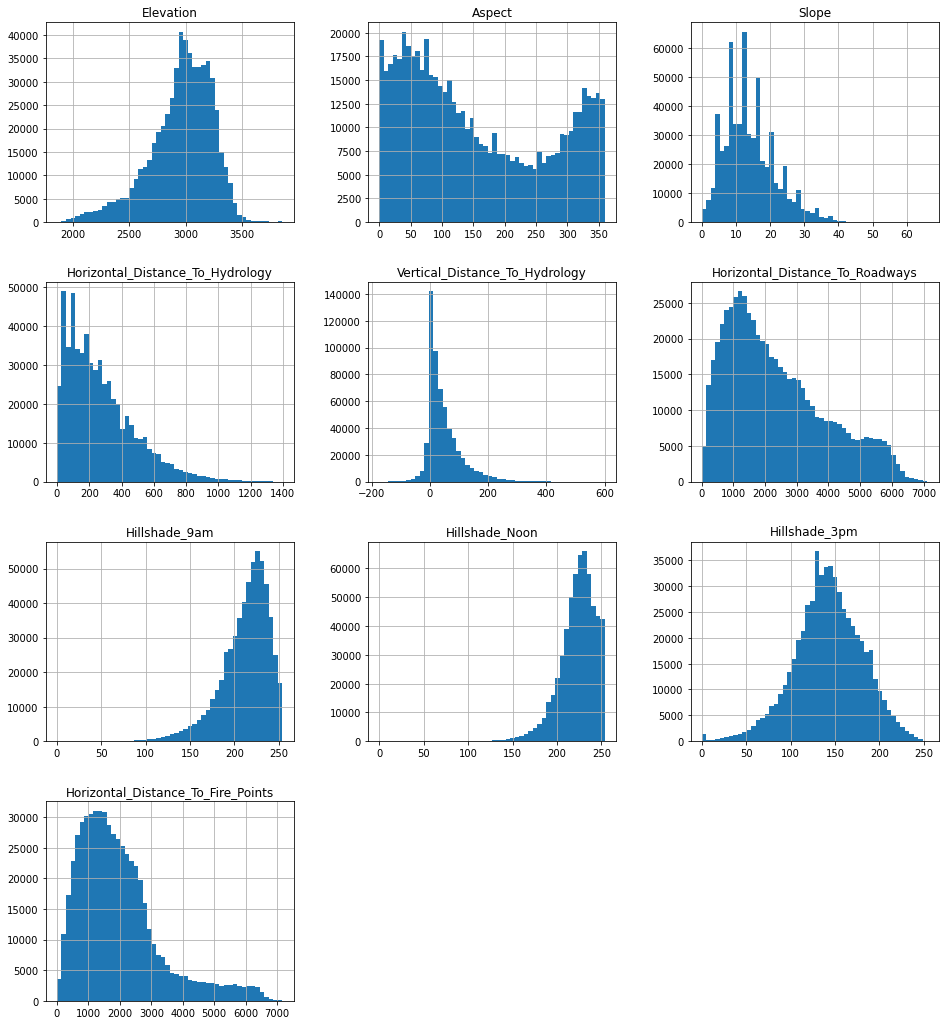

In [18]:
# Убираем признаки с сильными шумами так как вероятно, что признаки Soil, Wilderness негативно влияют на обучение модели
selected_feats = [x for x in feats if 'Soil' not in x and 'Wilderness' not in x]
train_copy[selected_feats].hist(figsize=(16,18),bins=50);

Feature engineering

In [19]:
# Перечислим все возможности, которые есть в Distance
[x for x in train_copy.columns if 'Distance' in x]

['Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Horizontal_Distance_To_Fire_Points']

In [20]:
#функция для создания новых признаков на основе дистанции и высоты дерева
def distance(x, y):
	return (x.astype('int32')**2 + y.astype('int32')**2) ** 0.5

train_copy['distance_HoHy_VeHy'] = distance(train_copy['Horizontal_Distance_To_Hydrology'], train_copy['Vertical_Distance_To_Hydrology'])
train_copy['distance_HoHy_HoRo'] = distance(train_copy['Horizontal_Distance_To_Hydrology'], train_copy['Horizontal_Distance_To_Roadways'])
train_copy['distance_HoHy_HoFi'] = distance(train_copy['Horizontal_Distance_To_Hydrology'], train_copy['Horizontal_Distance_To_Fire_Points'])
train_copy['distance_VeHy_HoRo'] = distance(train_copy['Vertical_Distance_To_Hydrology'], train_copy['Horizontal_Distance_To_Roadways'])
train_copy['distance_VeHy_HoFi'] = distance(train_copy['Vertical_Distance_To_Hydrology'], train_copy['Horizontal_Distance_To_Fire_Points'])
train_copy['distance_HoRo-HoFI'] = distance(train_copy['Horizontal_Distance_To_Roadways'], train_copy['Horizontal_Distance_To_Fire_Points'])

train_copy['minus_HoHy_VeHy'] = abs(train_copy['Horizontal_Distance_To_Hydrology'] - train_copy['Vertical_Distance_To_Hydrology'])
train_copy['minus_HoHy_HoRo'] = abs(train_copy['Horizontal_Distance_To_Hydrology'] - train_copy['Horizontal_Distance_To_Roadways'])
train_copy['minus_HoHy_HoFi'] = abs(train_copy['Horizontal_Distance_To_Hydrology'] - train_copy['Horizontal_Distance_To_Fire_Points'])
train_copy['minus_VeHy_HoRo'] = abs(train_copy['Vertical_Distance_To_Hydrology'] - train_copy['Horizontal_Distance_To_Roadways'])
train_copy['minus_VeHy_HoFi'] = abs(train_copy['Vertical_Distance_To_Hydrology'] - train_copy['Horizontal_Distance_To_Fire_Points'])
train_copy['minus_HoRo-HoFI'] = abs(train_copy['Horizontal_Distance_To_Roadways'] - train_copy['Horizontal_Distance_To_Fire_Points'])

train_copy['sum_HoHy_VeHy'] = train_copy['Horizontal_Distance_To_Hydrology'] + train_copy['Vertical_Distance_To_Hydrology']
train_copy['sum_HoHy_HoRo'] = train_copy['Horizontal_Distance_To_Hydrology'] + train_copy['Horizontal_Distance_To_Roadways']
train_copy['sum_HoHy_HoFi'] = train_copy['Horizontal_Distance_To_Hydrology'] + train_copy['Horizontal_Distance_To_Fire_Points']
train_copy['sum_VeHy_HoRo'] = train_copy['Vertical_Distance_To_Hydrology'] + train_copy['Horizontal_Distance_To_Roadways']
train_copy['sum_VeHy_HoFi'] = train_copy['Vertical_Distance_To_Hydrology'] + train_copy['Horizontal_Distance_To_Fire_Points']
train_copy['sum_HoRo-HoFI'] = train_copy['Horizontal_Distance_To_Roadways'] + train_copy['Horizontal_Distance_To_Fire_Points']

# Создание признаков для Elevation
train_copy['distance_Elev_VeHy'] = distance(train_copy['Elevation'], train_copy['Vertical_Distance_To_Hydrology'])
train_copy['distance_Elev_HoHy'] = distance(train_copy['Elevation'], train_copy['Horizontal_Distance_To_Hydrology'])
train_copy['distance_Elev_HoRo'] = distance(train_copy['Elevation'], train_copy['Horizontal_Distance_To_Roadways'])
train_copy['distance_Elev_HoFi'] = distance(train_copy['Elevation'], train_copy['Horizontal_Distance_To_Fire_Points'])


train_copy['minus_Elev_VeHy'] = abs(train_copy['Elevation'] - train_copy['Vertical_Distance_To_Hydrology'])
train_copy['minus_Elev_HoHy'] = abs(train_copy['Elevation'] - train_copy['Horizontal_Distance_To_Hydrology'])
train_copy['minus_Elev_HoRo'] = abs(train_copy['Elevation'] - train_copy['Horizontal_Distance_To_Roadways'])
train_copy['minus_Elev_HoFi'] = abs(train_copy['Elevation'] - train_copy['Horizontal_Distance_To_Fire_Points'])


train_copy['sum_Elev_VeHy'] = train_copy['Elevation'] + train_copy['Vertical_Distance_To_Hydrology']
train_copy['sum_Elev_HoHy'] = train_copy['Elevation'] + train_copy['Horizontal_Distance_To_Hydrology']
train_copy['sum_Elev_HoRo'] = train_copy['Elevation'] + train_copy['Horizontal_Distance_To_Roadways']
train_copy['sum_Elev_HoFi'] = train_copy['Elevation'] + train_copy['Horizontal_Distance_To_Fire_Points']

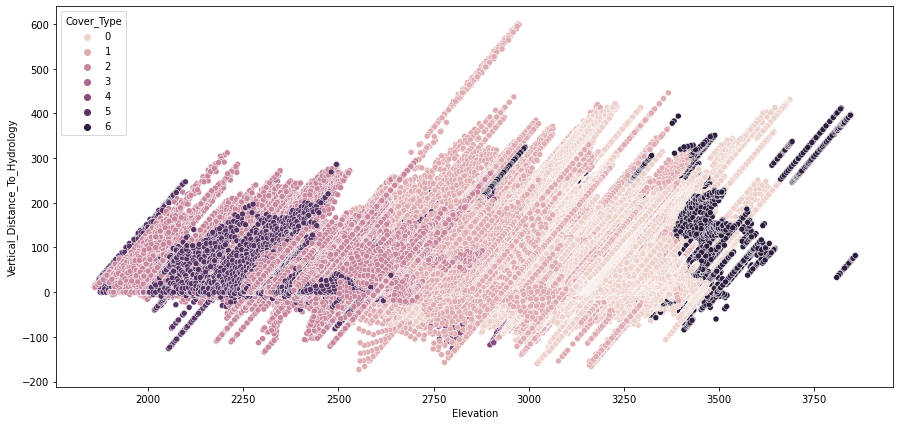

In [21]:
# график зависимостей между высотой дерева и дистанцией до воды
plt.figure(figsize=(15, 7))
sns.scatterplot(x='Elevation', y='Vertical_Distance_To_Hydrology', hue='Cover_Type', data=train_copy);

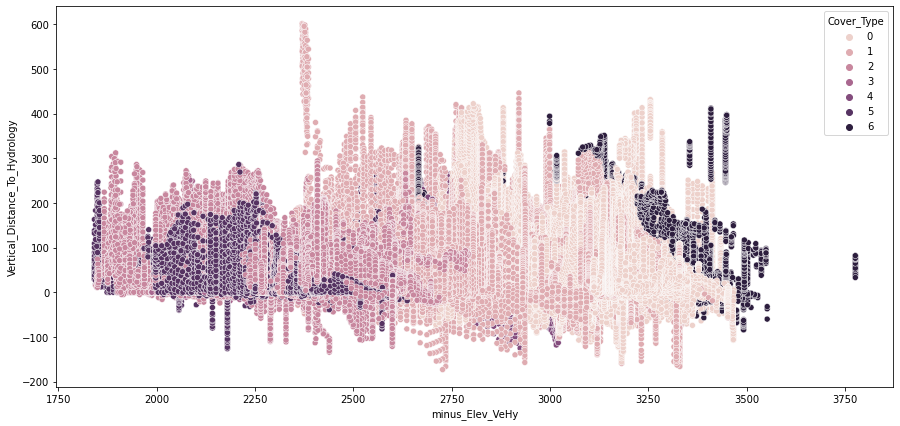

In [40]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x='minus_Elev_VeHy', y='Vertical_Distance_To_Hydrology', hue='Cover_Type', data=train_copy);

In [22]:
#Функция для обучения модели
def run_model(model, X, y, scoring='accuracy', cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True)):
	scores = []
	for train_idx, test_idx in cv.split(X, y):
		X_train, X_test = X[train_idx], X[test_idx]
		y_train, y_test = y[train_idx], y[test_idx]
		model.fit(X_train, y_train)
		y_pred = model.predict(X_test)

		score = accuracy_score(y_test, y_pred)
		scores.append(score)
	
	print(f'Ср.значение метрики успеха {round(np.mean(scores) * 100, 2)} %', f'Отклонение {np.std(scores)}')

	skplt.estimators.plot_learning_curve(model, X, y, figsize=(15,5), cv=cv, scoring=scoring)

	fig = plt.figure(figsize=(15,6))
	ax1 = fig.add_subplot(121)
	ax2 = fig.add_subplot(122)

	y_pred_matrix = cross_val_predict(model, X, y)
	skplt.metrics.plot_confusion_matrix(y, y_pred_matrix, normalize=True, ax=ax1)

	y_pred_proba = model.predict_proba(X)
	skplt.metrics.plot_roc(y, y_pred_proba, ax=ax2)
	plt.show()
	return model		#возвращаем модель для сохранения на диск

In [23]:
#получаем новые признаки и назначаем X-features, y-target
feats = get_feats(train_copy)
selected_feats = [x for x in feats if 'Soil' not in x and 'Wilderness' not in x]

X_1 = train_copy[selected_feats].values
y_1 = train_copy['Cover_Type'].values


In [24]:
#понижение размерности с помощью метода NearMiss
nr = NearMiss()
X_near, y_near = nr.fit_resample(X_1, y_1)

Тренировка моделей

1. KNeighborsClassifier

Ср.значение метрики успеха 91.56 % Отклонение 0.0019479452648913816


c:\Users\Алексей\AppData\Local\Programs\Python\Python39\lib\site-packages\scikitplot\metrics.py:156: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable=image)


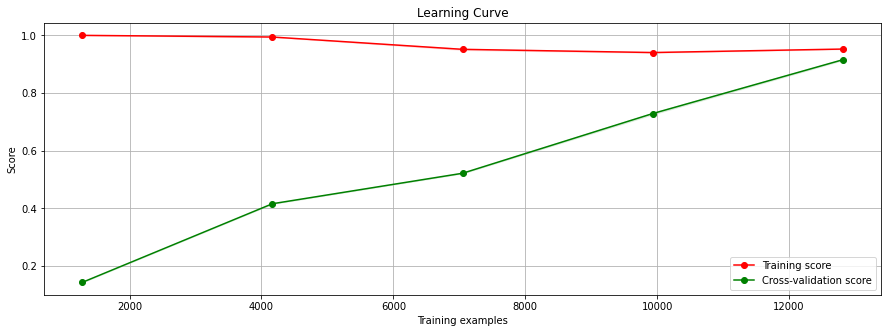

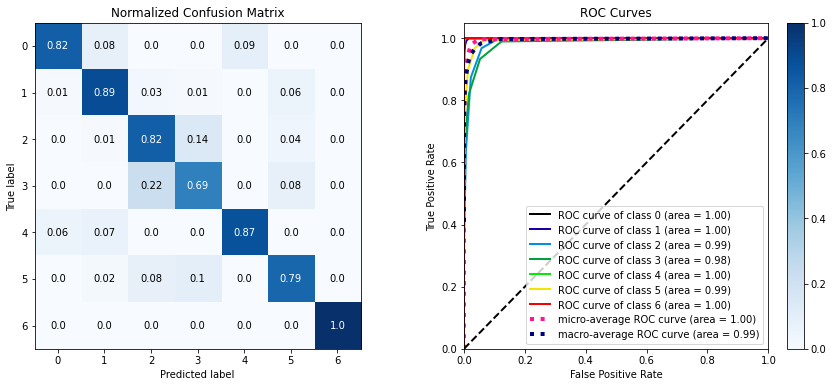

KNeighborsClassifier()

In [25]:
# accuracy - 91.56%
# std - 0.001
# time - 1m 39s
run_model(KNeighborsClassifier(n_neighbors=5), X_near, y_near)

2. DecisionTreeClassifier

Ср.значение метрики успеха 70.34 % Отклонение 0.0034374248606950215


c:\Users\Алексей\AppData\Local\Programs\Python\Python39\lib\site-packages\scikitplot\metrics.py:156: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable=image)


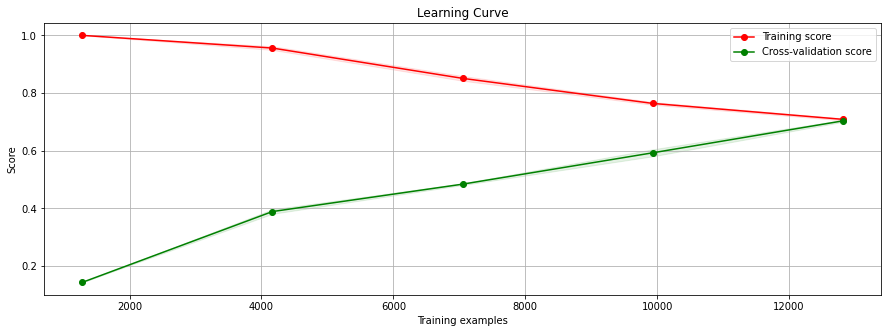

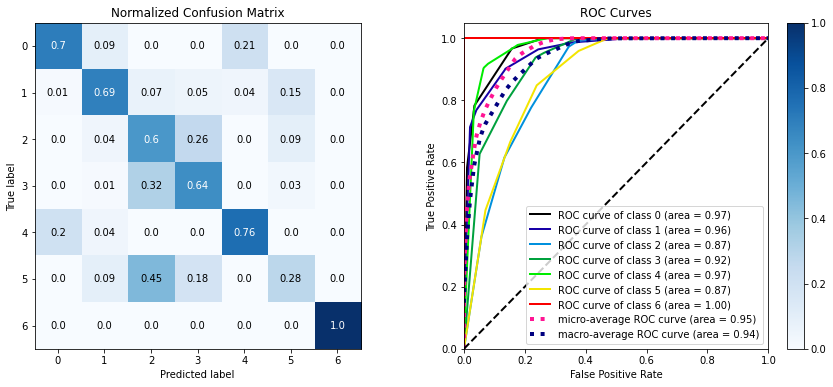

DecisionTreeClassifier(max_depth=5)

In [26]:
# accuracy - 70.34%
# std - 0.003
# time - 0m 13s
run_model(DecisionTreeClassifier(max_depth=5), X_near, y_near)

3. RandomForestClassifier

Ср.значение метрики успеха 83.09 % Отклонение 0.004820273711374962


c:\Users\Алексей\AppData\Local\Programs\Python\Python39\lib\site-packages\scikitplot\metrics.py:156: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable=image)


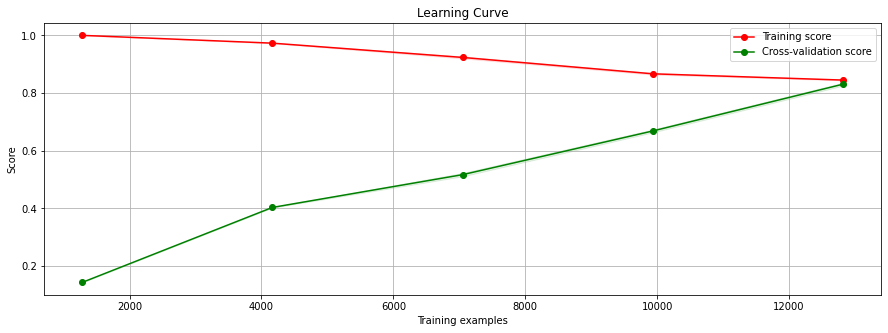

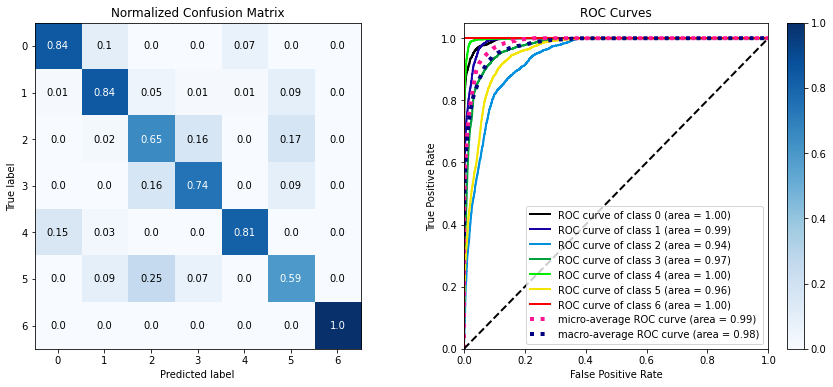

RandomForestClassifier(max_depth=7, random_state=0)

In [27]:
# accuracy - 83.09%
# std - 0.004
# time - 2m 04s
run_model(RandomForestClassifier(max_depth=7, n_estimators=100, random_state=0), X_near, y_near)

4. LGBMClassifier

Ср.значение метрики успеха 95.27 % Отклонение 0.0013997508962841428


c:\Users\Алексей\AppData\Local\Programs\Python\Python39\lib\site-packages\scikitplot\metrics.py:156: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable=image)


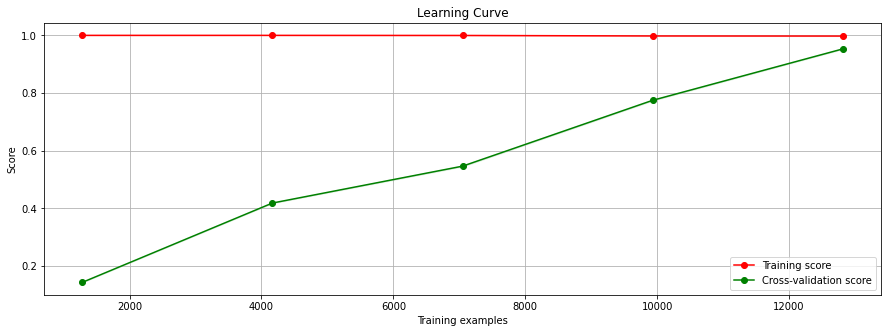

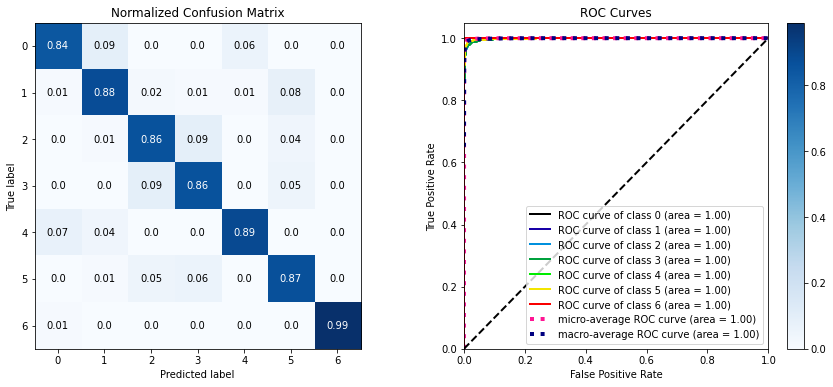

LGBMClassifier(colsample_bytree=0.6, max_depth=7, random_state=0)

In [28]:
# accuracy - 95.27%
# std - 0.001
# time - 1m 53s
run_model(lgbm.LGBMClassifier(max_depth=7, n_estimators=100, colsample_bytree=0.6, random_state=0), X_near, y_near)

In [ ]:
'''
Из 4 моделей лучше всех результат у LGBMClassifier.
Видно, что на обучающей выборке переобучение, но на тестовой тоже высокий процент, что позволяет сделать вывод о качестве модели
'''

Ср.значение метрики успеха 95.27 % Отклонение 0.0013997508962841428


c:\Users\Алексей\AppData\Local\Programs\Python\Python39\lib\site-packages\scikitplot\metrics.py:156: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable=image)


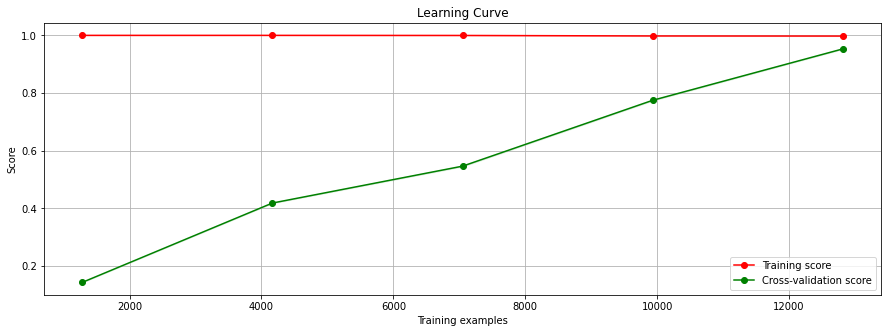

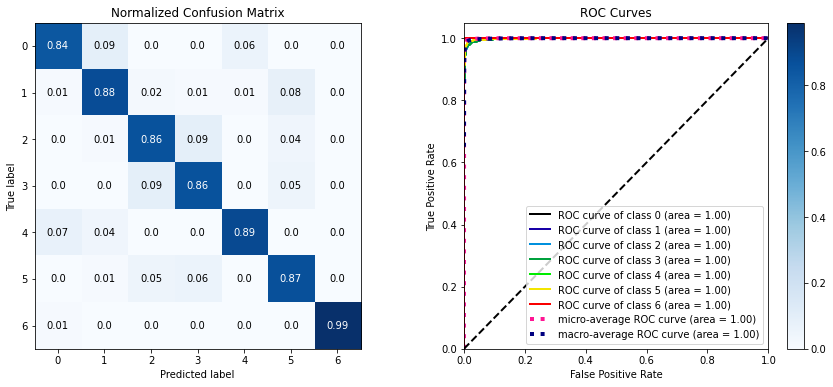

In [86]:
#сохранение модели c помощью pickle
import pickle
with open('model_lgmb.pkl', 'wb') as f:
	pickle.dump(run_model(lgbm.LGBMClassifier(max_depth=7, n_estimators=100, colsample_bytree=0.6, random_state=0), X_near, y_near), f)

Обучение нейронной сети

Импорт библиотек

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [31]:
# создадим стандартизатор
standard_scaler = StandardScaler()

In [32]:
# разделим выборку на train, test
X_net_train, X_net_test, y_net_train, y_net_test = train_test_split(X_near, y_near, test_size=0.2, random_state=1, shuffle=True)

In [33]:
#проверяем размерность
X_net_train.shape, X_net_test.shape, y_net_train.shape, y_net_test.shape

((15383, 40), (3846, 40), (15383,), (3846,))

In [34]:
# переводим целевые переменные в категориальные признаки
y_net_train_cat = to_categorical(y_net_train, 7)
y_net_test_cat = to_categorical(y_net_test, 7)

In [35]:
#Стандартизируем данные
X_net_train_std = standard_scaler.fit_transform(X_net_train)
X_net_test_std = standard_scaler.transform(X_net_test)

In [36]:
#входные параметры
input_shape = [X_net_train_std.shape[1]]


Создание и обучение модели

In [37]:
model_net = Sequential([
	Dense(units=128, activation='relu', input_shape=input_shape),
	Dense(units=64, activation='relu'),
	Dense(units=7, activation='softmax')
])

model_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5248      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 13,959
Trainable params: 13,959
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_net.compile(optimizer='adam',
						loss='categorical_crossentropy',
						metrics=['accuracy'])

In [39]:
losses= model_net.fit(X_net_train_std, y_net_train_cat,
							validation_data=(X_net_test_std, y_net_test_cat),
							batch_size=32,
							epochs=15)

Epoch 1/15
481/481 [==============================] - 4s 7ms/step - loss: 0.7128 - accuracy: 0.7140 - val_loss: 0.5187 - val_accuracy: 0.7904
Epoch 2/15
481/481 [==============================] - 3s 6ms/step - loss: 0.4612 - accuracy: 0.8093 - val_loss: 0.4334 - val_accuracy: 0.8227
Epoch 3/15
481/481 [==============================] - 3s 5ms/step - loss: 0.3909 - accuracy: 0.8410 - val_loss: 0.3753 - val_accuracy: 0.8518
Epoch 4/15
481/481 [==============================] - 3s 6ms/step - loss: 0.3473 - accuracy: 0.8624 - val_loss: 0.3411 - val_accuracy: 0.8580
Epoch 5/15
481/481 [==============================] - 3s 5ms/step - loss: 0.3191 - accuracy: 0.8702 - val_loss: 0.3296 - val_accuracy: 0.8658
Epoch 6/15
481/481 [==============================] - 3s 5ms/step - loss: 0.3007 - accuracy: 0.8783 - val_loss: 0.3145 - val_accuracy: 0.8786
Epoch 7/15
481/481 [==============================] - 3s 5ms/step - loss: 0.2822 - accuracy: 0.8852 - val_loss: 0.2903 - val_accuracy: 0.8864
Epoch 

In [40]:
model_net.evaluate(X_net_test_std, y_net_test_cat)

121/121 [==============================] - 1s 4ms/step - loss: 0.2703 - accuracy: 0.8983


[0.2703014016151428, 0.8983359336853027]